In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [7]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')

In [8]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem-ft_ELMo
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem_ELMo
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations/harem_ELMo+Embeddings


In [9]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            metrics[training_folder.name] = None
print(len(metrics))
print(len(configs))

32
32


In [10]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [15]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [18]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        
        print('Check id: %s' % training_id)

In [19]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'glove', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'word2vec', 'skip', '0', '0']
['harem', 'ELMo', '0', '0']
['harem', 'ELMo+CNN', '0', '0']


In [20]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,0,1,00:01:05,65.0,65.0,0.918712,0.925619,0.236206,0.139698,0.175563,235.699485,0.937165,0.942848,0.369272,0.349490,0.359109,115.783627,0.939287,0.944075,0.446098,0.410351,0.427478,123.022328
1,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,0,1,00:01:15,75.0,75.0,0.916439,0.923358,0.235723,0.148058,0.181878,237.231158,0.934652,0.940116,0.348052,0.341837,0.344916,113.868460,0.938266,0.942889,0.434340,0.413022,0.423413,122.355378
2,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,0,0,0,1,00:01:25,85.0,85.0,0.922708,0.929784,0.341309,0.130798,0.189121,232.470868,0.940990,0.946563,0.397436,0.395408,0.396419,109.531831,0.943550,0.948893,0.477794,0.445409,0.461033,115.920524
3,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,0,0,0,1,00:01:16,76.0,76.0,0.922787,0.929773,0.357386,0.141586,0.202820,222.618674,0.939023,0.944815,0.380319,0.364796,0.372396,109.989682,0.938867,0.944420,0.448225,0.409015,0.427723,118.109491
4,harem-ft_ELMo+CNN+Embeddings_glove_0_0,harem-ft,ELMo+CNN+Embeddings,glove,No,0,0,0,1,00:01:16,76.0,76.0,0.922798,0.929828,0.361905,0.143474,0.205485,221.799653,0.938258,0.944159,0.364611,0.346939,0.355556,108.475007,0.940308,0.945471,0.453678,0.428381,0.440666,116.953325
5,harem-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,cbow,0,0,0,1,00:01:15,75.0,75.0,0.922440,0.929414,0.357398,0.134844,0.195810,223.367938,0.940334,0.946345,0.386740,0.357143,0.371353,109.821152,0.940338,0.946011,0.459041,0.415359,0.436109,117.369796
6,harem-ft_ELMo+CNN+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,skip,0,0,0,1,00:01:16,76.0,76.0,0.922563,0.929470,0.358757,0.137001,0.198283,223.018302,0.938367,0.944705,0.368984,0.352041,0.360313,110.024080,0.939542,0.945381,0.445822,0.420367,0.432720,117.340651
7,harem-ft_ELMo+CNN+Embeddings_word2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,cbow,0,0,0,1,00:01:16,76.0,76.0,0.922652,0.929649,0.362129,0.141316,0.203298,223.159533,0.939897,0.946345,0.379404,0.357143,0.367937,109.926167,0.939617,0.945231,0.450273,0.412688,0.430662,117.892926
8,harem-ft_ELMo+CNN+Embeddings_word2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,skip,0,0,0,1,00:01:16,76.0,76.0,0.922742,0.929705,0.355828,0.140777,0.201739,222.390523,0.939242,0.945361,0.378378,0.357143,0.367454,108.990144,0.940308,0.945621,0.457299,0.418364,0.436966,116.783829
9,harem-ft_ELMo+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+Embeddings,fasttext,cbow,0,0,0,1,00:01:08,68.0,68.0,0.915879,0.923033,0.192767,0.139428,0.161815,244.436075,0.940116,0.946126,0.377309,0.364796,0.370947,110.632752,0.941899,0.947377,0.456925,0.419699,0.437522,118.010933


In [21]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [22]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:01:16.406250'

In [23]:
training_data_df.groupby([MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem,16.0,0.672360,0.036379,0.567070,0.679918,0.685406,0.689871,0.697922
harem-ft,16.0,0.434865,0.008477,0.423413,0.430024,0.433214,0.437105,0.461033


In [24]:
training_data_df.groupby([REPRESENTATION]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Representation,,,,,,,,
ELMo,2.0,0.560353,0.187913,0.427478,0.493915,0.560353,0.626790,0.693227
ELMo+CNN+Embeddings,14.0,0.557569,0.126461,0.427723,0.436323,0.530959,0.686801,0.697922
ELMo+Embeddings,14.0,0.550814,0.124492,0.428111,0.433862,0.503827,0.682463,0.688991
ELMo+CNN,2.0,0.538760,0.163125,0.423413,0.481086,0.538760,0.596433,0.654107


In [25]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
skip,12.0,0.559193,0.131683,0.427723,0.432980,0.559499,0.685166,0.692512
No,8.0,0.556006,0.134081,0.423413,0.431665,0.547387,0.687577,0.693227
cbow,12.0,0.546436,0.118526,0.430662,0.435922,0.514052,0.681100,0.697922


In [26]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,4.0,0.562456,0.145057,0.433060,0.438765,0.563886,0.687577,0.688991
word2vec,8.0,0.561696,0.135176,0.430662,0.436065,0.559499,0.685486,0.697922
wang2vec,8.0,0.559483,0.135214,0.428111,0.434700,0.558264,0.683370,0.693743
No,4.0,0.549556,0.144207,0.423413,0.426462,0.540793,0.663887,0.693227
fasttext,8.0,0.537264,0.111768,0.427723,0.436408,0.514052,0.621894,0.685885


In [27]:
training_data_df.groupby([MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean  std  \
Model    Representation      Embedding Embedding_Type                         
harem    ELMo+CNN+Embeddings word2vec  cbow              1.0  0.697922  NaN   
                             wang2vec  cbow              1.0  0.693743  NaN   
         ELMo                No        No                1.0  0.693227  NaN   
         ELMo+CNN+Embeddings word2vec  skip              1.0  0.692512  NaN   
         ELMo+Embeddings     glove     No                1.0  0.688991  NaN   
                             wang2vec  skip              1.0  0.687368  NaN   
         ELMo+CNN+Embeddings glove     No                1.0  0.687106  NaN   
                             fasttext  skip              1.0  0.685885  NaN   
         ELMo+Embeddings     fasttext  skip              1.0  0.684927  NaN   
                             word2vec  cbow              1.0  0.683144  NaN   
         ELMo+CNN+Embeddings wang2vec  skip              1.0  0.682037  NaN   
         ELMo+Embeddings     wang2vec  cbow              1.0  0.680419  NaN   
                             word2vec  skip              1.0  0.678414  NaN   
         ELMo+CNN            No        No                1.0  0.654107  NaN   
         ELMo+CNN+Embeddings fasttext  cbow              1.0  0.600884  NaN   
         ELMo+Embeddings     fasttext  cbow              1.0  0.567070  NaN   
harem-ft ELMo+CNN+Embeddings fasttext  cbow              1.0  0.461033  NaN   
                             glove     No                1.0  0.440666  NaN   
         ELMo+Embeddings     word2vec  skip              1.0  0.440585  NaN   
                             fasttext  cbow              1.0  0.437522  NaN   
         ELMo+CNN+Embeddings word2vec  skip              1.0  0.436966  NaN   
                             wang2vec  cbow              1.0  0.436109  NaN   
         ELMo+Embeddings     wang2vec  cbow              1.0  0.435360  NaN   
                             word2vec  cbow              1.0  0.433362  NaN   
                             fasttext  skip              1.0  0.433067  NaN   
                             glove     No                1.0  0.433060  NaN   
         ELMo+CNN+Embeddings wang2vec  skip              1.0  0.432720  NaN   
                             word2vec  cbow              1.0  0.430662  NaN   
         ELMo+Embeddings     wang2vec  skip              1.0  0.428111  NaN   
         ELMo+CNN+Embeddings fasttext  skip              1.0  0.427723  NaN   
         ELMo                No        No                1.0  0.427478  NaN   
         ELMo+CNN            No        No                1.0  0.423413  NaN   

                                                            min       25%  \
Model    Representation      Embedding Embedding_Type                       
harem    ELMo+CNN+Embeddings word2vec  cbow            0.697922  0.697922   
                             wang2vec  cbow            0.693743  0.693743   
         ELMo                No        No              0.693227  0.693227   
         ELMo+CNN+Embeddings word2vec  skip            0.692512  0.692512   
         ELMo+Embeddings     glove     No              0.688991  0.688991   
                             wang2vec  skip            0.687368  0.687368   
         ELMo+CNN+Embeddings glove     No              0.687106  0.687106   
                             fasttext  skip            0.685885  0.685885   
         ELMo+Embeddings     fasttext  skip            0.684927  0.684927   
                             word2vec  cbow            0.683144  0.683144   
         ELMo+CNN+Embeddings wang2vec  skip            0.682037  0.682037   
         ELMo+Embeddings     wang2vec  cbow            0.680419  0.680419   
                             word2vec  skip            0.678414  0.678414   
         ELMo+CNN            No        No              0.654107  0.654107   
         ELMo+CNN+Embeddings fasttext  cbow            0.600884  0.600884   
         ELMo+Embeddings     fasttext  cbow            0.56

In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,6.0,0.816528,0.001683,0.813934,0.815556,0.816913,0.817726,0.818307
glove,No,6.0,0.814727,0.004899,0.806057,0.813607,0.815352,0.817960,0.819745
none,No,6.0,0.813248,0.005673,0.807491,0.808201,0.812555,0.818403,0.819782
FastText,skip,6.0,0.812207,0.004859,0.807071,0.808402,0.812399,0.813720,0.820144
word2vec,skip,6.0,0.811659,0.002892,0.808050,0.809654,0.811403,0.813698,0.815567
wang2vec,cbow,6.0,0.811240,0.006997,0.804752,0.805015,0.810690,0.816496,0.819755
word2vec,cbow,6.0,0.809821,0.003093,0.804293,0.808869,0.810842,0.811804,0.812614
FastText,cbow,6.0,0.808001,0.003964,0.803723,0.805622,0.806477,0.811038,0.813433


In [15]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df

,Training_ID,Model,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem_glove_4_0,harem,glove,No,4,0,14,20,00:20:37,1237.0,61.85,0.998710,0.998778,0.984774,0.983437,0.984105,2.518672,0.986825,0.988212,0.898515,0.870504,0.884287,38.845473,0.978612,0.980323,0.836111,0.804007,0.819745,86.923718
7,harem_FastText_skip_0_0,harem,FastText,skip,0,0,17,20,00:21:17,1277.0,63.85,0.998813,0.998925,0.986250,0.986516,0.986383,2.618697,0.980549,0.982625,0.809639,0.857143,0.832714,80.307844,0.977531,0.979287,0.813922,0.800334,0.807071,102.638994
8,harem_FastText_skip_1_0,harem,FastText,skip,1,0,14,20,00:21:48,1308.0,65.40,0.998960,0.999073,0.988137,0.986010,0.987072,2.408293,0.988150,0.989146,0.891534,0.879896,0.885677,39.415561,0.978071,0.979692,0.827897,0.796661,0.811979,93.129816
9,harem_FastText_skip_2_0,harem,FastText,skip,2,0,17,20,00:22:39,1359.0,67.95,0.998512,0.998637,0.983733,0.983191,0.983462,2.875621,0.985239,0.986389,0.859470,0.895966,0.877339,61.577133,0.976901,0.978882,0.830742,0.784975,0.807210,112.155598
10,harem_FastText_skip_3_0,harem,FastText,skip,3,0,16,20,00:22:29,1349.0,67.45,0.998581,0.998705,0.983198,0.982399,0.982798,2.891299,0.985611,0.986646,0.857143,0.884521,0.870617,64.158647,0.978402,0.980293,0.842068,0.799332,0.820144,103.418668
11,harem_FastText_skip_4_0,harem,FastText,skip,4,0,19,20,00:20:43,1243.0,62.15,0.998608,0.998733,0.984795,0.984795,0.984795,2.917401,0.987816,0.989104,0.892157,0.872902,0.882424,60.121636,0.977831,0.979737,0.830373,0.795993,0.812820,115.126372
12,harem_FastText_skip_5_0,harem,FastText,skip,5,0,10,20,00:20:38,1238.0,61.90,0.998714,0.998838,0.985896,0.986431,0.986164,3.007601,0.985893,0.986806,0.867925,0.886747,0.877235,49.205531,0.977666,0.979422,0.829979,0.798664,0.814021,78.271919
13,harem_glove_0_0,harem,glove,No,0,0,13,20,00:21:43,1303.0,65.15,0.998444,0.998567,0.982475,0.982740,0.982608,3.014718,0.979674,0.982188,0.832474,0.823980,0.828205,70.347586,0.978251,0.980038,0.845853,0.793322,0.818746,92.917678
14,harem_glove_1_0,harem,glove,No,1,0,14,20,00:21:29,1289.0,64.45,0.998485,0.998564,0.983252,0.979284,0.981264,3.108251,0.988150,0.989245,0.882051,0.898172,0.890039,41.233481,0.978251,0.979887,0.823009,0.807346,0.815102,87.214743
15,harem_glove_2_0,harem,glove,No,2,0,16,20,00:22:15,1335.0,66.75,0.998694,0.998841,0.983751,0.984293,0.984022,2.923189,0.986485,0.987540,0.865306,0.900212,0.882414,51.642144,0.977831,0.979662,0.825077,0.806344,0.815603,94.902028


In [16]:
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,6.0,0.816528,0.001683,0.813934,0.815556,0.816913,0.817726,0.818307
glove,6.0,0.814727,0.004899,0.806057,0.813607,0.815352,0.817960,0.819745
none,6.0,0.813248,0.005673,0.807491,0.808201,0.812555,0.818403,0.819782
FastText,6.0,0.812207,0.004859,0.807071,0.808402,0.812399,0.813720,0.820144
word2vec,6.0,0.811659,0.002892,0.808050,0.809654,0.811403,0.813698,0.815567


In [17]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df

,Training_ID,Model,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem_glove_4_0,harem,glove,No,4,0,14,20,00:20:37,1237.0,61.85,0.998710,0.998778,0.984774,0.983437,0.984105,2.518672,0.986825,0.988212,0.898515,0.870504,0.884287,38.845473,0.978612,0.980323,0.836111,0.804007,0.819745,86.923718
1,harem_FastText_cbow_0_0,harem,FastText,cbow,0,0,18,20,00:21:34,1294.0,64.70,0.996238,0.996574,0.956864,0.951187,0.954017,6.895696,0.979565,0.981860,0.820449,0.839286,0.829760,64.836776,0.977726,0.979587,0.826612,0.800668,0.813433,78.893459
2,harem_FastText_cbow_1_0,harem,FastText,cbow,1,0,17,20,00:21:25,1285.0,64.25,0.996257,0.996619,0.959741,0.955609,0.957671,6.895422,0.987652,0.988449,0.876289,0.887728,0.881971,35.038665,0.977261,0.979167,0.814751,0.792988,0.803723,79.718814
3,harem_FastText_cbow_2_0,harem,FastText,cbow,2,0,17,20,00:22:48,1368.0,68.40,0.996468,0.996808,0.959246,0.953431,0.956329,6.074136,0.985047,0.985910,0.851406,0.900212,0.875129,44.350892,0.978011,0.979827,0.815825,0.809015,0.812406,72.494512
4,harem_FastText_cbow_3_0,harem,FastText,cbow,3,0,15,20,00:22:32,1352.0,67.60,0.996386,0.996746,0.960609,0.957487,0.959045,6.666629,0.983230,0.984161,0.833718,0.886978,0.859524,46.980135,0.977246,0.979152,0.813646,0.800334,0.806935,70.731598
5,harem_FastText_cbow_4_0,harem,FastText,cbow,4,0,7,20,00:20:33,1233.0,61.65,0.996504,0.996809,0.963582,0.955471,0.959509,6.776945,0.986528,0.987915,0.877108,0.872902,0.875000,34.727985,0.976826,0.978657,0.807370,0.804674,0.806020,59.603659
6,harem_FastText_cbow_5_0,harem,FastText,cbow,5,0,12,20,00:20:43,1243.0,62.15,0.996310,0.996649,0.961674,0.960109,0.960891,6.725093,0.986096,0.987009,0.860849,0.879518,0.870083,40.272384,0.977486,0.979257,0.817681,0.793656,0.805490,70.806180
13,harem_glove_0_0,harem,glove,No,0,0,13,20,00:21:43,1303.0,65.15,0.998444,0.998567,0.982475,0.982740,0.982608,3.014718,0.979674,0.982188,0.832474,0.823980,0.828205,70.347586,0.978251,0.980038,0.845853,0.793322,0.818746,92.917678
14,harem_glove_1_0,harem,glove,No,1,0,14,20,00:21:29,1289.0,64.45,0.998485,0.998564,0.983252,0.979284,0.981264,3.108251,0.988150,0.989245,0.882051,0.898172,0.890039,41.233481,0.978251,0.979887,0.823009,0.807346,0.815102,87.214743
15,harem_glove_2_0,harem,glove,No,2,0,16,20,00:22:15,1335.0,66.75,0.998694,0.998841,0.983751,0.984293,0.984022,2.923189,0.986485,0.987540,0.865306,0.900212,0.882414,51.642144,0.977831,0.979662,0.825077,0.806344,0.815603,94.902028


In [18]:
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,6.0,0.814727,0.004899,0.806057,0.813607,0.815352,0.817960,0.819745
none,6.0,0.813248,0.005673,0.807491,0.808201,0.812555,0.818403,0.819782
wang2vec,6.0,0.811240,0.006997,0.804752,0.805015,0.810690,0.816496,0.819755
word2vec,6.0,0.809821,0.003093,0.804293,0.808869,0.810842,0.811804,0.812614
FastText,6.0,0.808001,0.003964,0.803723,0.805622,0.806477,0.811038,0.813433


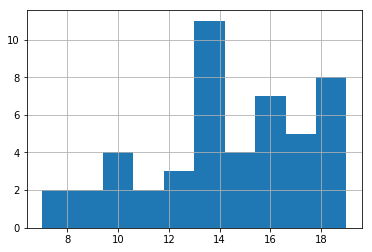

In [19]:
training_data_df[BEST_EPOCH].hist()

In [20]:
training_data_df[TOTAL_DURATION].describe()

count      48.000000
mean     1290.958333
std        41.573804
min      1226.000000
25%      1243.000000
50%      1295.000000
75%      1321.750000
max      1368.000000
Name: Total_Duration(s), dtype: float64

In [21]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
3,8.0,0.813565,0.005056,0.806935,0.809814,0.813712,0.817076,0.820144
5,8.0,0.813552,0.005304,0.805490,0.810975,0.814794,0.817010,0.819782
2,8.0,0.812632,0.005544,0.804293,0.807840,0.814004,0.816627,0.819487
4,8.0,0.812502,0.005193,0.804752,0.810391,0.812430,0.815775,0.819745
0,8.0,0.810824,0.004679,0.805129,0.807479,0.809627,0.813912,0.818746
1,8.0,0.809999,0.003998,0.803723,0.808159,0.810528,0.812468,0.815102


In [22]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,48.0,0.812179,0.004904,0.000708,0.810755,0.813603


In [23]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
FastText,12,0.810104,0.004765,0.001375,0.807408,0.812800
glove,6,0.814727,0.004899,0.002000,0.810807,0.818647
none,6,0.813248,0.005673,0.002316,0.808708,0.817787
wang2vec,12,0.813884,0.005583,0.001612,0.810725,0.817043
word2vec,12,0.810740,0.003012,0.000869,0.809036,0.812444


In [24]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [25]:
print_anova(EMBEDDING)

Overall model F( 4, 43) =  1.736, p =  0.15956710898573892021
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     1.736
Date:                Tue, 21 May 2019   Prob (F-statistic):              0.160
Time:                        09:41:24   Log-Likelihood:                 191.24
No. Observations:                  48   AIC:                            -372.5
Df Residuals:                      43   BIC:                            -363.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------